# CAPM vs Machine Learning Models
Compare CAPM benchmark with multiple ML regression techniques to forecast excess returns.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor


In [6]:
# Load and merge data
df = pd.read_csv("crspm_and_predictors_50k.csv")
rf_df = pd.read_csv("TB3MS.csv")
rf_df['observation_date'] = pd.to_datetime(rf_df['observation_date'])
rf_df.rename(columns={'observation_date': 'yyyymm', 'TB3MS': 'RiskFree'}, inplace=True)
rf_df['RiskFree'] = rf_df['RiskFree'] / 100
df['yyyymm'] = pd.to_datetime(df['yyyymm'], format='%Y%m')
df = pd.merge(df, rf_df, on='yyyymm', how='left')
df['ExcessReturn'] = df['ret'] - df['RiskFree']


In [7]:
leaky_predictors = [
    "EarningsSurprise", "AnnouncementReturn", "NumEarnIncrease",
    "NetEquityFinance", "NetDebtFinance", "DebtIssuance",
    "ShareIss5Y", "EquityDuration", "EarnSupBig", "CBOperProf"
]
predictor_columns = [col for col in df.columns if col not in ['permno', 'yyyymm', 'ret', 'RiskFree', 'prc', 'Price', 'ExcessReturn'] + leaky_predictors]
df = df.fillna(0)
X = df[predictor_columns].fillna(0)
y = df['ExcessReturn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [8]:
results = []

def evaluate_model(name, model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    results.append({'Model': name, 'R2': r2, 'MSE': mse})

# Linear
evaluate_model("Linear Regression", LinearRegression())

# Polynomial
evaluate_model("Polynomial (deg=2)", make_pipeline(PolynomialFeatures(2), LinearRegression()))

# Lasso
evaluate_model("Lasso", LassoCV(cv=5))

# Ridge
evaluate_model("Ridge", RidgeCV(cv=5))

# ElasticNet
evaluate_model("ElasticNet", ElasticNetCV(cv=5))

# SVR
evaluate_model("SVR", make_pipeline(StandardScaler(), SVR()))

# Random Forest
evaluate_model("Random Forest", RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42))

# XGBoost
evaluate_model("XGBoost", XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42))

# PCA + Linear
evaluate_model("PCA + Linear", make_pipeline(StandardScaler(), PCA(n_components=10), LinearRegression()))

# PLS Regression
evaluate_model("PLS Regression", PLSRegression(n_components=10))

# Neural Net
evaluate_model("Neural Network", MLPRegressor(hidden_layer_sizes=(64, 64), max_iter=500, random_state=42))


/Users/arshad/Documents/prog/python/env/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=3.22401e-32): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/arshad/Documents/prog/python/env/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=3.22515e-32): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/arshad/Documents/prog/python/env/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=3.23429e-32): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/arshad/Documents/prog/python/env/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=1.56361e-30): result may not be accurate.
  return linalg.solve(A, Xy, assume_a

In [9]:
results_df = pd.DataFrame(results).sort_values(by='R2', ascending=False)
results_df.reset_index(drop=True, inplace=True)
results_df


,Model,R2,MSE
0,Ridge,9.999985e-01,5.254036e-04
1,PLS Regression,9.996034e-01,1.413694e-01
2,Random Forest,9.810943e-01,6.739606e+00
3,XGBoost,9.302541e-01,2.486341e+01
4,SVR,5.714566e-01,1.527695e+02
5,PCA + Linear,4.503581e-01,1.959394e+02
6,Linear Regression,-1.138472e-04,3.565261e+02
7,Polynomial (deg=2),-2.058445e-04,3.565589e+02
8,Lasso,-2.059801e-04,3.565590e+02
9,ElasticNet,-2.059801e-04,3.565590e+02


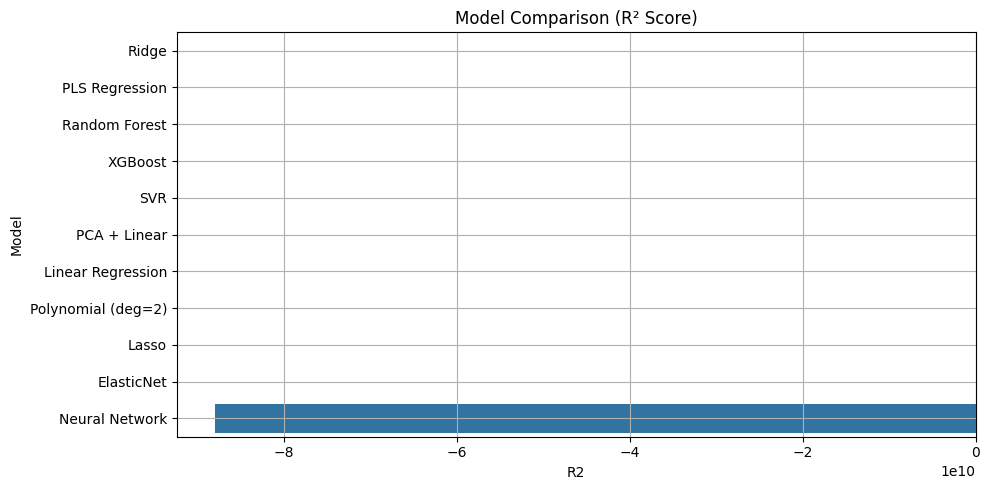

In [10]:
plt.figure(figsize=(10, 5))
sns.barplot(data=results_df, x='R2', y='Model')
plt.title("Model Comparison (R² Score)")
plt.grid(True)
plt.tight_layout()
plt.show()
